# Notebook to analyse integrated xenopus scRNA-seq datasets

## Imports

In [32]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony

import random
np.random.seed(0)
random.seed(0)

## Settings

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
sc.settings.verbosity = 0

# Load data

In [7]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

### Harmony discrete timeseries alignment

In [9]:
from Integrate import concat_for_harmony, adata_to_df

In [10]:
timepoints = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , timepoints)
counts = concat_for_harmony(adatas, timepoints)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])




st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [11]:
#Make cluster colorsfor integrated dataset
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [12]:


sns.palplot(colors.sort_values('clust_order').color)

In [13]:
spring = pd.read_csv('../embeddings/SPRING_integrated_coordinates.txt', header = None, index_col = 0)
spring.columns = ['x', 'y']
spring.index = counts.index

In [14]:

tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [15]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}\.[S|L]'.format(gene))])

## Run Palantir

In [16]:
#Load affinity matrix
with open('./intermediate_files/aug_aff', "rb") as f:
    aug_aff = pickle.load( f)

In [17]:
#Diffusion maps for palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff,n_components=20,
    knn=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [18]:
#Magic imputation
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

In [19]:
#Set random seed
import random
np.random.seed(100)
random.seed(100)

In [18]:
#Run palantir with predefined terminal cells

# Start cell
start_cell = 'st08_AAACGGGCAGTCAGCC'

#Terminal cells
terminal_cells = [ 'st22_CTACATTGTAAGCGGT',
       'st22_CTCACTGTCCCGAATA', 'st22_CTGCTCAAGCCTCAAT',
       'st27_CGTCAGGAGGTGGGTT']

pr_res = palantir.core.run_palantir(ms_data, start_cell, terminal_states=terminal_cells,
                use_early_cell_as_start=False)

Sampling and flocking waypoints...
Time for determining waypoints: 0.06618038018544516 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.8235666592915852 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9996
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [19]:
#Name the braches
pr_res.branch_probs.columns = ['Stem cells', 'Goblet cells', 'Ionocytes', 'MCC']


In [23]:
pr_res.branch_probs.to_csv('Sup_tables/branch_probs.tsv', sep = '\t')

In [25]:
pr_res.pseudotime.to_csv('Sup_tables/Palantir_pseudotime.tsv', sep = '\t')

In [26]:
pr_res.entropy.to_csv('Sup_tables/Palantir_dp.tsv', sep = '\t')

In [28]:
tp.to_csv('Sup_tables/stages.tsv', sep = '\t')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


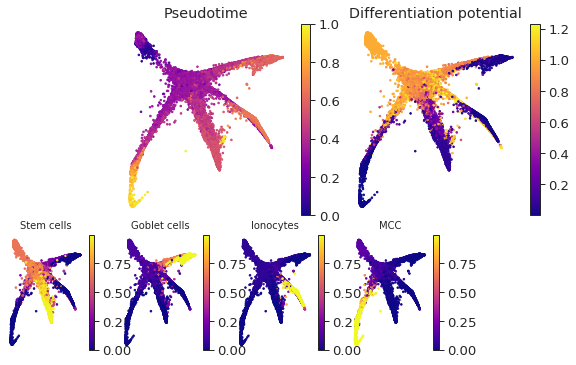

In [20]:
#Plot palantir pseudotime and differentiation potential
palantir.plot.plot_palantir_results(pr_res, spring)

In [20]:
#vars(pr_res)
#with open('presult', 'wb') as pickle_file:
#    pr_res.save(pickle_file)


with open('presult', "rb") as f:
    pr_res = pickle.load( f)

In [21]:
# Start cell
start_cell = 'st08_AAACGGGCAGTCAGCC'

#Terminal cells
terminal_cells = [ 'st22_CTACATTGTAAGCGGT',
       'st22_CTCACTGTCCCGAATA', 'st22_CTGCTCAAGCCTCAAT',
       'st27_CGTCAGGAGGTGGGTT']

fig, axs = plt.subplots(1,5, figsize = (15,3))
axs = np.ravel(axs)
cmap = matplotlib.cm.plasma
for idx, i in enumerate(pr_res['_branch_probs'].columns):
    c = pr_res['_branch_probs'][i]
    normalize = matplotlib.colors.Normalize(
        vmin=0, vmax=1)
    
    axs[idx].scatter(spring.loc[:, 'x'], spring.loc[:, 'y'], s=3, c = c, cmap = cmap, vmin = 0, vmax = 1)

    axs[idx].scatter(spring.loc[start_cell, 'x'], spring.loc[start_cell, 'y'], s=25, color='red')
    axs[idx].scatter(spring.loc[terminal_cells[idx], 'x'], spring.loc[terminal_cells[idx], 'y'], s=25, color='red')
    
    axs[idx].set_title(i)
    axs[idx].set_axis_off()
    axs[idx].set_rasterized(True)
    
cax, _ = matplotlib.colorbar.make_axes(axs[4], location = 'left', fraction = 0.4, anchor =(0.5, 1.0), aspect = 0.2)
cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap, orientation='horizontal', label = 'Branch Probabilities')
axs[4].set_axis_off()
plt.savefig('figures/Branch_probabilities.pdf')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


In [23]:
#Remove non-informative gene names


data = norm_df.copy()
genes_sub = [x for x in data.columns if 'LOC' not in x]
genes_sub = [x for x in genes_sub if 'Xetrov' not in x]
genes_sub = [x for x in genes_sub if 'Xelaev' not in x]
genes_sub = [x for x in genes_sub if 'MGC' not in x]
genes_sub = [x for x in genes_sub if '|loc' not in x]
print('Subsetting to {} genes'.format(len(genes_sub)))
data = data.loc[:,genes_sub]

Subsetting to 13189 genes


In [43]:
pr_res['_branch_probs'].columns

Index(['Stem cells', 'Goblet cells', 'Ionocytes', 'MCC'], dtype='object')

In [57]:
gene_rank = data.corrwith(pr_res['_branch_probs']['MCC'])


In [58]:
gene_rank = gene_rank.sort_values(ascending = False)



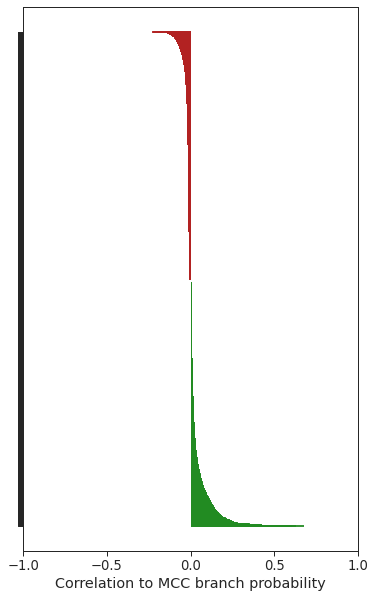

In [62]:
num = round(len(gene_rank.index) / 5)
sub = pd.concat([gene_rank[0:num], gene_rank[-num:]])
plt.figure(figsize = (6, 10))
plt.hlines(y = sub.index,#list([x.split('|')[1] for x in sub.index]), 
           xmin = 0, xmax = sub, color = [*['forestgreen']*num, *['firebrick']*num], linewidth = 2, alpha = 0.9)
plt.yticks( fontsize = 10)
a = plt.gca()
a.set_yticklabels([] )
plt.xlabel('Correlation to MCC branch probability')
plt.xticks(np.arange(-1, 1+1, 0.5))
plt.xlim((-1, 1))
plt.savefig('./figures/corr_MCC_difp_20p.pdf',dpi = 500 )

In [21]:
#Modified palantir methods!
def plot_palantir_results(pr_res, tsne):
    """ Plot Palantir results on tSNE
    """

    # Set up figure
    n_branches = pr_res.branch_probs.shape[1]
    n_cols = 6
    n_rows = int(np.ceil(n_branches / n_cols))
    fig = plt.figure(figsize=[2 * n_cols, 2 * (n_rows + 2)])
    gs = plt.GridSpec(n_rows + 2, n_cols,
                      height_ratios=np.append([0.75, 0.75], np.repeat(1, n_rows)))
    cmap = matplotlib.cm.plasma
    # Pseudotime
    ax = plt.subplot(gs[0:2, 1:3])
    c = pr_res.pseudotime[tsne.index]
    ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=3,
               cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(
        vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    ax.set_title('Pseudotime')
    ax.set_rasterized(True)

    # Entropy
    ax = plt.subplot(gs[0:2, 3:5])
    c = pr_res.entropy[tsne.index]
    ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=3,
               cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(
        vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    ax.set_title('Differentiation potential')
    ax.set_rasterized(True)

    # Branch probabilities
    order = [2, 3, 1, 4, 0, 5]
    row = 2
    for i, branch in enumerate(pr_res.branch_probs.columns):
        row = int(np.floor(i / n_cols))
        ax = plt.subplot(gs[row + 2, order[i]])
        c = pr_res.branch_probs.loc[tsne.index, branch]
        ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=3,
                   cmap=matplotlib.cm.plasma, c=c)
        normalize = matplotlib.colors.Normalize(
            vmin=np.min(c), vmax=np.max(c))
        cax, _ = matplotlib.colorbar.make_axes(ax)
        cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
        ax.set_axis_off()
        ax.set_title(branch, fontsize=10)
        ax.set_rasterized(True)

In [22]:
#Modified palantir methods!

def plot_pseudotime(tsne, pseudo):
    """ Plot Palantir results on tSNE
    """

    # Set up figure

    n_cols = 6
    n_rows = int(np.ceil(6 / n_cols))
    fig = plt.figure(figsize=[2 * n_cols, 2 * (n_rows + 2)])
    gs = plt.GridSpec(n_rows + 2, n_cols,
                      height_ratios=np.append([0.75, 0.75], np.repeat(1, n_rows)))
    cmap = matplotlib.cm.plasma
    # Pseudotime
    ax = plt.subplot(gs[0:2, 1:3])
    c = pseudo[tsne.index]
    ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=3,
               cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(
        vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    #ax.set_title('Pseudotime')
    ax.set_rasterized(True)


In [25]:
#Plot the palantir results on SPRING graph
plot_palantir_results(pr_res, spring)
plt.savefig('./intermediate_files/Figures/Palantir_result.pdf',dpi = 500 )

In [21]:
#Load global clustering
with open('./intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [31]:
clusters.to_csv('Sup_tables/phenograph_clusters.tsv', sep = '\t')

In [21]:
cc_phase = pd.read_csv('cc_phase.tsv', sep = '\t', index_col = 0, header = None)
cc_phase.columns = ['phase']

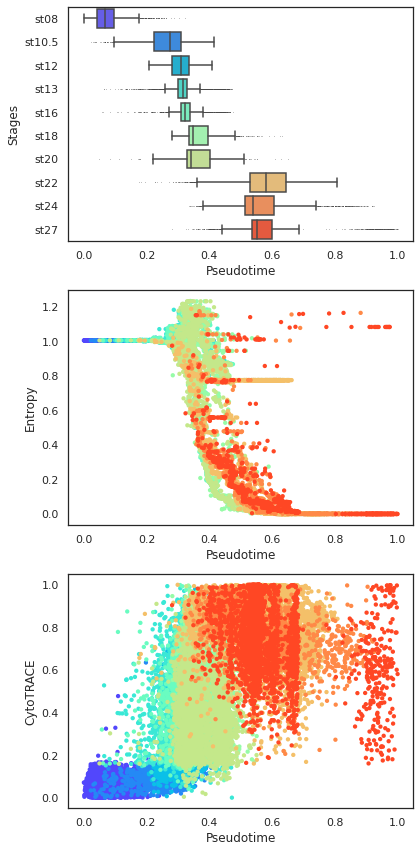

In [72]:
fig, axs = plt.subplots(3,1, figsize=(6, 12), facecolor='w')
axs = axs.ravel()   

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.color_palette(
            'rainbow', 10)

# Create the data
x = pr_res['_pseudotime']
g = tp
df = pd.DataFrame({'Pseudotime':x, 'Stages':g})
sns.boxplot( y = 'Stages',x =  'Pseudotime', data = df, palette=pal,fliersize=0.1, orient = 'h' , ax = axs[0])
axs[0].set_rasterized(True)

data = pd.DataFrame({'Pseudotime':pr_res['_pseudotime'],
             'Entropy':pr_res['_entropy']})
sns.scatterplot('Pseudotime', 'Entropy', data = data, hue = tp[spring.index], #alpha = 0.5,
                linewidths = 0, ax = axs[1], palette=pal, legend = False, marker = '.',edgecolor="none", s = 75)
plt.xlabel('Pseudotime')
plt.ylabel('Differentiation Potential')
#axs[1].set_rasterized(True)
data = pd.DataFrame({'Pseudotime':pr_res['_pseudotime'],
             'CytoTRACE':cyto['CytoTRACE']})
sns.scatterplot('Pseudotime', 'CytoTRACE', data = data, hue = tp[spring.index], #alpha = 0.5,
                linewidths = 0, ax = axs[2], palette=pal, legend = False, marker = '.',edgecolor="none", s = 75)

axs[1].set_rasterized(True)
axs[2].set_rasterized(True)
plt.xlabel('Pseudotime')
plt.ylabel('CytoTRACE')
plt.tight_layout()

plt.savefig('./intermediate_files/Figures/dfp_vs_pt.pdf',dpi = 500)

 ### Compare Palantir pseudotime to CytoTRACE pseudotime 

In [67]:
cyto = pd.read_csv('../Cytotrace/CytoTRACE_plot_table.txt', sep = '\t')

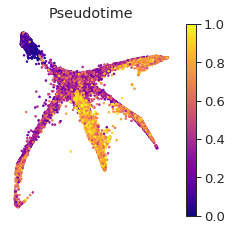

In [204]:
plot_pseudotime(spring, cyto['CytoTRACE'])
plt.savefig('./intermediate_files/Figures/CytoTRACE_pseudotime.pdf',dpi = 500 )

In [36]:
cv = pd.read_csv('CV.tsv', sep = '\t', index_col = 0, header = None)
cv.columns = ['CV']

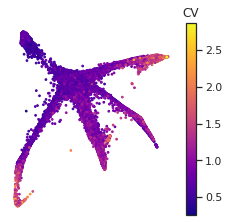

In [90]:
cv = pd.read_csv('CV.tsv', sep = '\t', index_col = 0, header = None)
cv.columns = ['CV']
plot_pseudotime(spring, cv['CV'])
plt.title('CV')
plt.savefig('figures/CV_spring_graph.pdf')

## Clustering the graph using phenograph

In [30]:
clusters = palantir.utils.determine_cell_clusters(ms_data, k = 1000)

Finding 1000 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 14.040509462356567 seconds
Jaccard graph constructed in 587.2679340839386 seconds
Wrote graph to binary file in 109.8370270729065 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.866441
After 4 runs, maximum modularity is Q = 0.867764
Louvain completed 24 runs in 250.00378513336182 seconds
PhenoGraph complete in 966.0094859600067 seconds


In [21]:
import pickle
#with open('./intermediate_files/clusters', "wb") as f:
#    pickle.dump(clusters, f)
    
with open('./intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [22]:
from IntegratedAnalysis import plot_cell_clusters, plot_comp_clusters

In [16]:
#Setup colormap for stages
cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])

In [17]:
louvain_over_colors = {'0_st08':'#DBDBDB', '0_st10.5':'#BDBDBD', '0_st12':'#9F9F9F', '0_st13':'#42D600', '0_st16':'#54D91B', '0_st18':'#66DD36', '0_st20':'#8AE46C', '0_st22':'#F39A86', '0_st24':'#F5F13D', '0_st27':'#E88573', '10_st22':'#F4C5F7', '10_st24':'#893BB0', '10_st27':'#BB3129', '11_st22':'#A16CB7', '11_st24':'#D9695A', '11_st27':'#B4EDAB', '12_st24':'#DD7061', '12_st27':'#710AA9', '13_st24':'#F09380', '1_st12':'#828282', '1_st13':'#B0E6F8', '1_st16':'#92D4F9', '1_st18':'#6CDE3F', '1_st20':'#58B0FB', '1_st22':'#FFFDB8', '1_st24':'#CA4D41', '1_st27':'#F0EB00', '2_st13':'#48D709', '2_st16':'#5ADA24', '2_st18':'#72DF48', '2_st20':'#90E575', '2_st22':'#F7A18C', '2_st24':'#EC8C79', '2_st27':'#B01C16', '3_st13':'#4ED812', '3_st16':'#60DC2D', '3_st18':'#75C2FA', '3_st20':'#96E67E', '3_st22':'#FBA892', '3_st24':'#1E8CFD', '3_st27':'#E986FD', '4_st18':'#78E051', '4_st20':'#9CE887', '4_st22':'#FAF77A', '4_st24':'#CE5448', '4_st27':'#E47E6D', '5_st18':'#7EE25A', '5_st20':'#A2E990', '5_st22':'#DE8F80', '5_st24':'#D25B4E', '5_st27':'#B4231C', '6_st18':'#84E363', '6_st20':'#A8EA99', '6_st22':'#3B9EFC', '6_st24':'#BF382F', '6_st27':'#AC1510', '7_st22':'#E17767', '7_st24':'#D56254', '7_st27':'#C33F35', '8_st22':'#FFAF99', '8_st24':'#C6463B', '8_st27':'#017AFE', '9_st22':'#AEEBA2', '9_st24':'#EEA5FA', '9_st27':'#B72A22'}



In [18]:
#Load per stage clustering
with open('local_clusters', "rb") as f:
    clusters_local_ind = pickle.load( f)
    
local_overclust = pd.concat([clusters_local_ind, tp], axis = 1)
local_overclust.columns = ['clusters', 'stages']
local_overclust['group'] = local_overclust["clusters"].astype(str) + '_' +local_overclust["stages"]

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


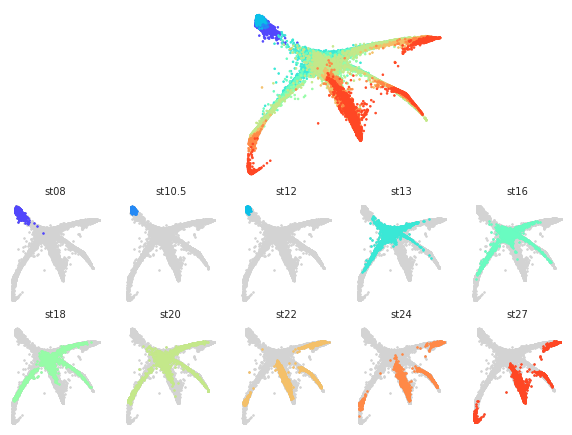

In [20]:
cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])

plot_cell_clusters(spring, tp, cluster_colors=cluster_colors, cluster_order = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])
#plt.savefig('./intermediate_files/Figures/FA2_stages.pdf',dpi = 500 )

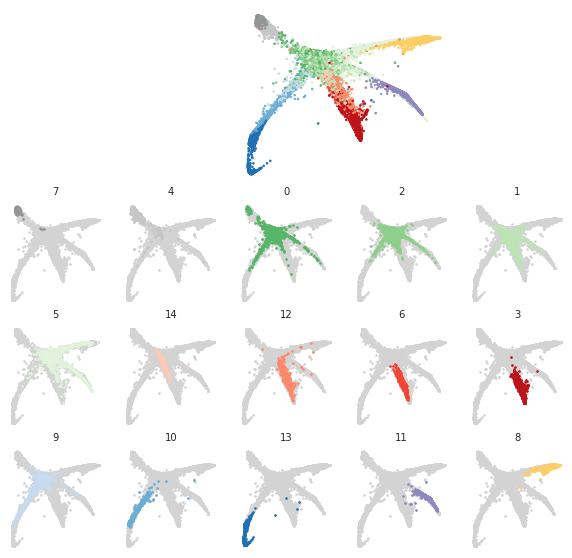

In [38]:
plot_cell_clusters(spring, clusters, cluster_colors=colors.color, cluster_order=colors.sort_values('clust_order').org_clust)
#plt.savefig('./intermediate_files/Figures/FA2_pheno_clust_V2.pdf',dpi = 500 )

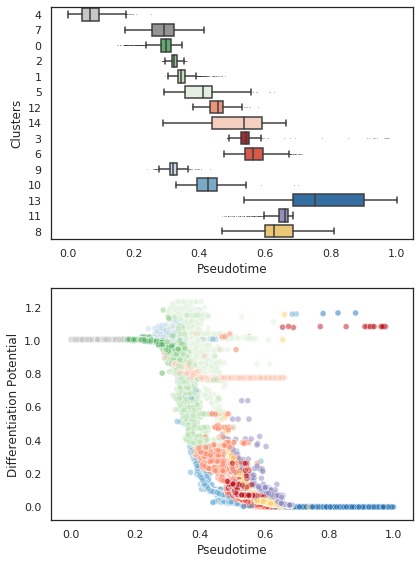

In [28]:
order = [4,7,0,2,1,5,12,14,3,6,9,10,13,11,8]

fig, axs = plt.subplots(2,1, figsize=(6, 8), facecolor='w')
axs = axs.ravel()   

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.color_palette(
            'rainbow', 10)

# Create the data
x = pr_res.pseudotime
g = tp
df = pd.DataFrame({'Pseudotime':x, 'Stages':g})
df['Clusters'] = clusters


sns.boxplot( y = 'Clusters',x =  'Pseudotime', data = df, palette=colors.iloc[[4,7,0,2,1,5,12,14,3,6,9,10,13,11,8]].color, fliersize=0.1, orient = 'h' , ax = axs[0], order = colors.iloc[[4,7,0,2,1,5,12,14,3,6,9,10,13,11,8]].org_clust)
axs[0].set_rasterized(True)

data = pd.DataFrame({'Pseudotime':pr_res.pseudotime,
             'Entropy':pr_res.entropy})
sns.scatterplot('Pseudotime', 'Entropy', data = data, hue = clusters[spring.index], alpha = 0.5, linewidths = 0, ax = axs[1], palette=colors.color.to_dict(), legend = False)
axs[1].set_rasterized(True)
plt.xlabel('Pseudotime')
plt.ylabel('Differentiation Potential')
plt.tight_layout()


#plt.savefig('./intermediate_files/Figures/tets.pdf',dpi = 500)
plt.savefig('figures/dfp_vs_pt_celltype.pdf',dpi = 500)

## Cell type frequencies

In [108]:
df = pd.DataFrame({'cluster':clusters,
             'stage':tp})

df['id'] = df.index
df_cluster = df.groupby(['stage', 'cluster']).count() #

df_cluster['frac'] = [df_cluster.loc[i][0] / df.groupby(['stage']).count()['id'][i[0]] for i in df_cluster.index]


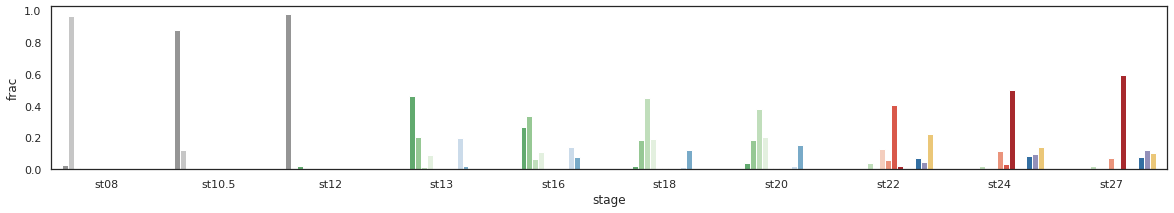

In [112]:
plt.figure(figsize=(20,3))
sns.barplot('stage', 'frac', hue = 'cluster', data = df_cluster.reset_index(), palette=colors.color.to_dict(), hue_order = colors.sort_values('clust_order', ascending = True).org_clust )
plt.legend().remove()

In [66]:
map_dict = colors[['org_clust', 'clust_order']].to_dict()['clust_order']

In [67]:
df = pd.DataFrame({'cluster':pd.DataFrame(clusters.map(map_dict))[0],
             'stage':tp})

In [31]:
df = pd.DataFrame({'cluster':clusters,
             'stage':tp})

df['Number'] = 1
stage_cluster = df.groupby(['stage', 'cluster']).agg({'Number': 'sum'})
# Change: groupby state_office and divide by sum
stage_pcts = stage_cluster.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

stage_pcts.reset_index(inplace = True)
stage_pcts = stage_pcts.pivot('stage', 'cluster', 'Number').loc[:,colors.sort_values('clust_order').org_clust]
stage_pcts.index = range(1,11)
stage_pcts

cluster,7,4,0,2,1,5,14,12,6,3,8,11,9,10,13
1,2.728873,96.361502,0.909624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87.866772,12.133228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97.695853,0.115207,2.188940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.068693,0.583891,46.333505,20.522068,1.339516,9.119011,0.103040,NaN,NaN,NaN,NaN,NaN,19.749270,2.181006,NaN
5,NaN,0.369004,26.875769,33.733087,6.488315,10.854859,0.061501,NaN,NaN,NaN,NaN,NaN,13.929889,7.687577,NaN
6,NaN,NaN,2.365184,18.330180,44.843898,18.897824,0.307474,0.969726,NaN,0.023652,0.449385,0.212867,1.371807,12.086093,0.141911
7,NaN,0.115942,3.826087,18.550725,38.028986,20.347826,1.072464,0.695652,NaN,NaN,0.057971,0.086957,1.971014,15.072464,0.173913
8,NaN,0.019150,0.268097,0.153198,4.174646,0.402145,12.849483,5.553428,40.616622,1.953275,22.194561,4.576791,0.019150,0.268097,6.951360
9,NaN,NaN,NaN,0.032185,1.963309,0.675893,0.804635,11.457998,3.121983,49.758610,13.968458,9.816543,NaN,0.032185,8.368201
10,NaN,NaN,0.029665,NaN,1.839217,0.860279,0.593296,7.060220,0.148324,59.507565,10.115693,12.014239,NaN,0.059330,7.772174


In [30]:
#Make cluster colors:

#Need 15 different
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 13],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 15], 
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 16], 
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 14], 
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 17], 
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

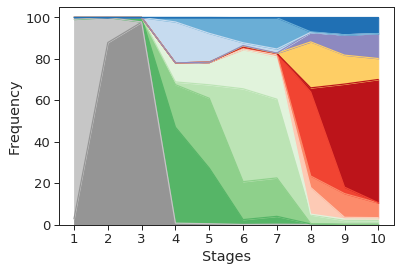

In [32]:
ax = stage_pcts.plot.area(color = colors.sort_values('clust_order').color, legend = False, )
ax.set_ylabel('Frequency')
ax.set_xticks( range(1,11))
ax.set_xlabel('Stages')
#plt.show()
plt.savefig('./intermediate_files/Figures/stack_area_final.pdf')

## Gene trends

In [22]:
def plot_gene_trends(gene_trends, cmap ,genes=None, save = True, legend = False):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """

    
    gene_name = genes[0].split('|')[1]
    # Branches and genes
    branches = list(gene_trends.keys())
    
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    fig = plt.figure(figsize=[7, 3 * len(genes)])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(len(genes), 1, i + 1)
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=cmap[branch], label=branch
            )
            ax.set_xticks([0, 1])
            ax.fill_between(
                trends.columns,
                trends.loc[gene, :] - stds.loc[gene, :],
                trends.loc[gene, :] + stds.loc[gene, :],
                alpha=0.1,
                color=cmap[branch],
            )
            ax.set_title(gene_name)
        # Add legend
        if i == 0 and legend:
            ax.legend()
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')

    sns.despine()
    if save:
        plt.savefig('GAM_figures/{}_trends.pdf'.format(gene_name))

In [23]:
ends = pr_res.branch_probs.columns.values.tolist()


In [25]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
            imp_df, ends)

Stem cells
Time for processing Stem cells: 6.809584363301595 minutes
Goblet cells
Time for processing Goblet cells: 5.805524682998657 minutes
Ionocytes
Time for processing Ionocytes: 5.35093119541804 minutes
MCC
Time for processing MCC: 5.229863969484965 minutes


In [26]:
cmap = {'Stem cells':colors.loc[3].color, 
       'Goblet cells':colors.loc[8].color,
       'Ionocytes':colors.loc[11].color, 
       'MCC':colors.loc[13].color, }

In [34]:
#Gene lists

known_markers =  ['gene94|pou5f3.2.L', 'gene5617|tubb4b.L','gene1174|angpt4.S', 'gene2352|foxa1.L','gene1736|tp63.L', 'gene13635|atp6v1g3.S' ]
MCC_markers = ['gene45756|cav-3', 'gene5617|tubb4b.L','gene5870|dynll1.L', 'gene19027|mycbp.L', 'gene5854|tekt2.S', 'gene933|dnali1.S', 'gene6831|meig1.S', 'gene16696|cfap45.S', 'gene46200|ccdc63.S', 'gene48102|LOC108714608', 'gene5681|dynlrb2.L']
progenitor_markers = ['gene15250|eef1a1o.L', 'gene4142|cirbp.L', 'gene11052|ncl.S', 'gene12364|has1.S', 'gene1566|hmgn1.L', 'gene888|zc3h10.S', 'gene8127|nsep1']
goblet_markers = ['gene42537|otog.L', 'gene16436|itln1.L', 'gene45777|LOC108696889', 'gene7461|LOC108700425', 'gene15239|fucolectin.S', 'gene721|atp12a.L','gene35324|hspa5', 'gene6178|sytl1.S', 'gene36159|capn9.S', 'gene1174|angpt4.S']
ionocyte_markers = ['gene13635|atp6v1g3.S', 'gene45646|atp6v1b1.L', 'gene4819|ca2.L', 'gene20453|atp6a1', 'gene8777|txn.L', 'gene3019|foxi1.L', 'gene1|slc26a4.L','gene15013|cystm1.S', 'gene18434|cox7a2.S']
pluripotency_markers = ['gene12224|hist1h2aa.L', 'gene7291|gmnn.S', 'gene94|pou5f3.2.L', 'gene13271|sox3.S', 'gene10103|hmgb3.L',  'gene8954|marcksl1.S', 'gene17236|anp32c.L', 'gene9078|ccna2.L', 'gene2965|srsf7.S', 'gene4112|bmp7.2.L','gene17314|sox15.L', 'gene79|foxi4.2.S', 'gene8954|marcksl1.S', 'gene8397|ccnb1.2.L', 'gene12214|h1foo.S', 'gene18794|tdgf1.3.L', 'gene2527|rbm7.L']
stem_markers = ['gene555|tmsb4x.L', 'gene38919|LOC108709680', 'gene13442|pfn1.L', 'gene21629|Xelaev18022166m',  'gene45261|LOC108698272','gene11920|ly6g6c.L', 'gene3817|s100a11.L', 'gene646|anxa2.S', 'gene10886|rplp1.L', 'gene51016|tpm4.S', 'gene1736|tp63.L']



['gene94|pou5f3.2.L', 'gene5617|tubb4b.L','gene15250|eef1a1o.L', 'gene42537|otog.L', 'gene13635|atp6v1g3.S', 'gene13442|pfn1.L']



In [39]:
early_MCC = ['gene4519|ccno.S', 'gene49198|mcidas', 'gene12208|arl2bp.L']
early_basal =  ['gene37785|ano1.L', 'gene2352|foxa1.L', 'gene14901|kcna4.S']

In [70]:
genes = ['gene1736|tp63.L',
'gene45646|atp6v1b1.L', 
'gene42537|otog.L', 
'gene16436|itln1.L', 
'gene13442|pfn1.L', 
'gene13000|foxa1.S', 
'gene9638|spdef.S', 
'gene5854|tekt2.S']

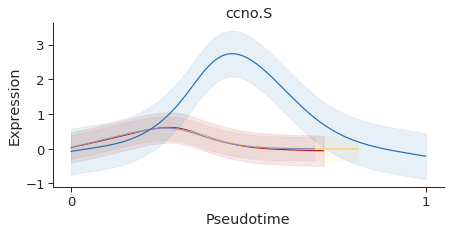

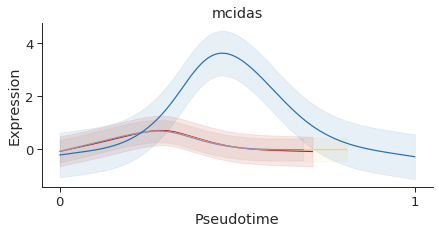

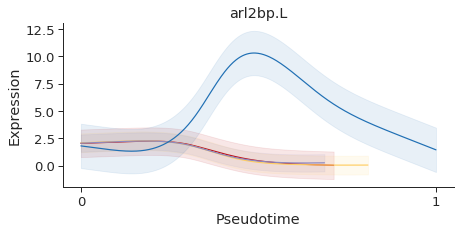

In [41]:
for i in early_MCC:
    try:
        plot_gene_trends(gene_trends, cmap = cmap, genes = [i], save = True)
    except:
        pass

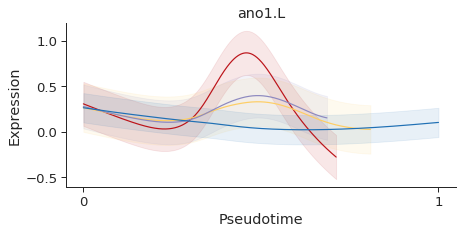

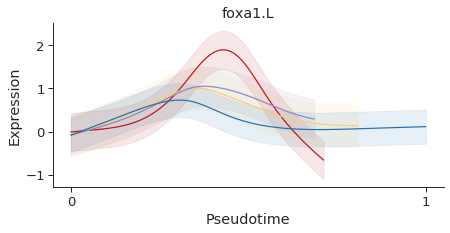

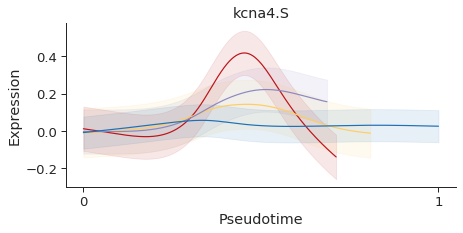

In [42]:
for i in early_basal:
    try:
        plot_gene_trends(gene_trends, cmap = cmap, genes = [i], save = True)
    except:
        pass

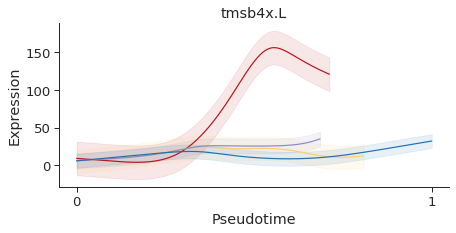

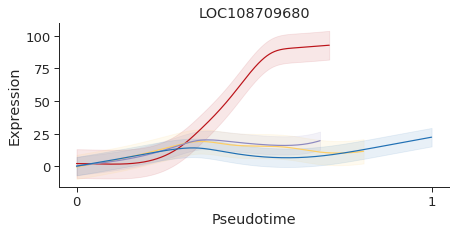

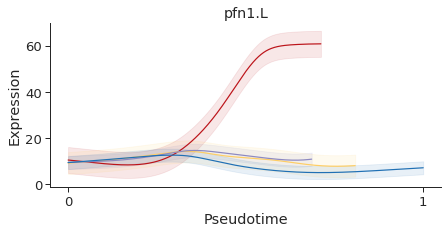

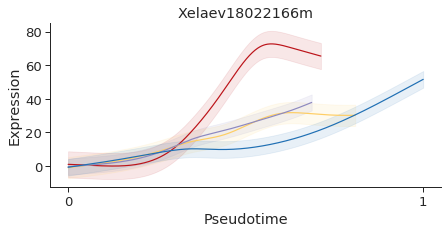

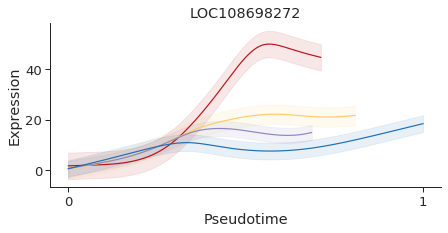

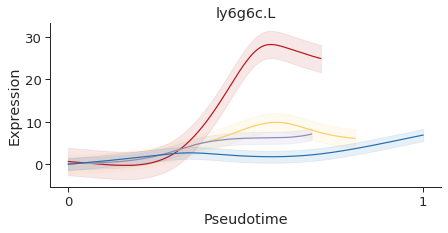

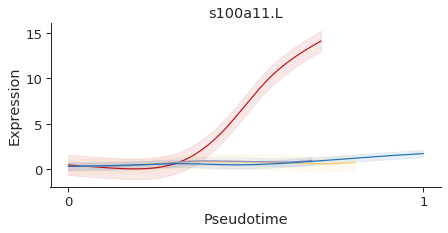

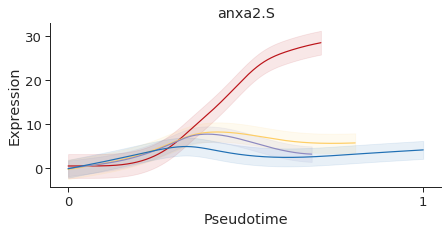

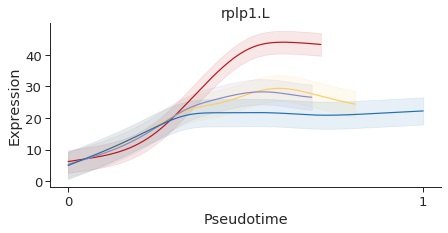

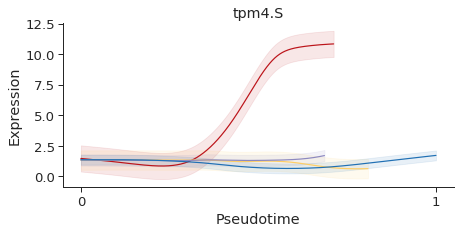

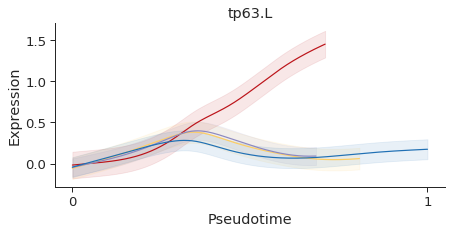

In [48]:
for i in stem_markers:
    try:
        plot_gene_trends(gene_trends, cmap = cmap, genes = [i], save = True)
    except:
        pass

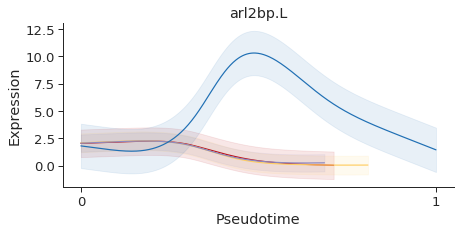

In [49]:
plot_gene_trends(gene_trends, cmap = cmap, genes = ['gene12208|arl2bp.L'], save = True)

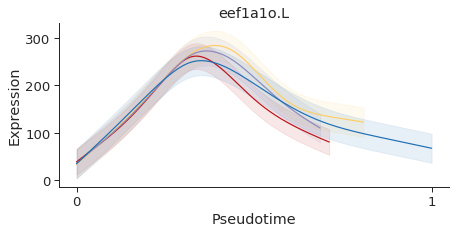

In [51]:
plot_gene_trends(gene_trends, cmap = cmap, genes = ['gene15250|eef1a1o.L'], save = True)

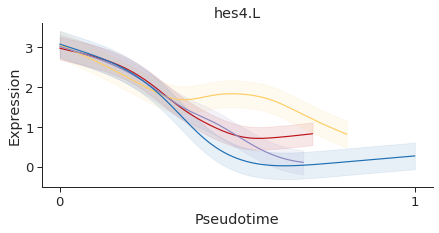

In [53]:
plot_gene_trends(gene_trends, cmap = cmap, genes = ['gene19742|hes4.L'], save = True)

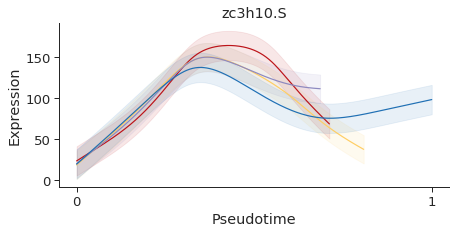

In [55]:
plot_gene_trends(gene_trends, cmap = cmap, genes = ['gene888|zc3h10.S'], save = True)

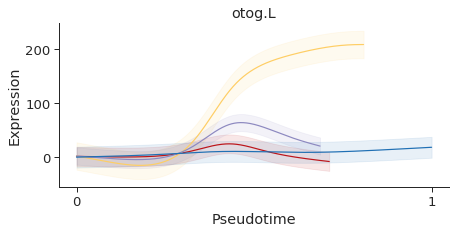

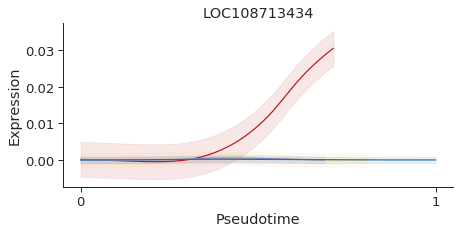

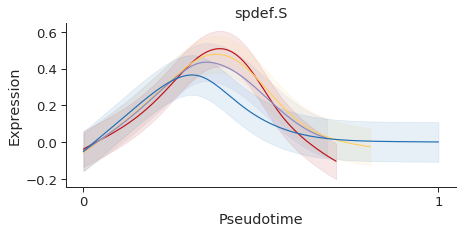

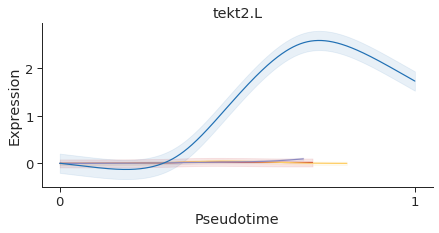

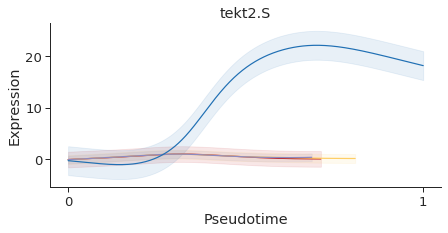

In [52]:
genes = ['gene42537|otog.L', 'gene40111|LOC108713434', 'gene9638|spdef.S','gene7275|tekt2.L', 'gene5854|tekt2.S']

for i in genes:
    try:
        plot_gene_trends(gene_trends, cmap = cmap, genes = [i], save = True)
    except:
        pass